In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/kvasir_dataset.zip .

In [3]:
!unzip -qq kvasir_dataset.zip

In [4]:
imagePaths = "kvasir_dataset/train/"
test_path = "kvasir_dataset/test/"

In [5]:
batch_size=32
img_height = 128
img_width = 128

In [6]:
import tensorflow as tf

In [7]:
!rm -rf kvasir_dataset/train/.ipynb_checkpoints

In [8]:
!ls -al kvasir_dataset/test/

total 164
drwxr-xr-x 8 root root  4096 Jan 17 10:36 .
drwxr-xr-x 5 root root  4096 Jan 17 10:39 ..
drwxr-xr-x 2 root root 20480 Jan 17 10:34 dyed-lifted-polyps
drwxr-xr-x 2 root root 28672 Jan 17 10:35 dyed-resection-margins
drwxr-xr-x 2 root root 24576 Jan 17 10:35 esophagitis
drwxr-xr-x 2 root root 36864 Jan 17 10:36 normal
drwxr-xr-x 2 root root 24576 Jan 17 10:36 polyps
drwxr-xr-x 2 root root 24576 Jan 17 10:37 ulcerative-colitis


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 13005 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 2295 files for validation.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  #seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.


In [12]:
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00


In [13]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

In [14]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = batch_size
num_epochs = 25

In [15]:
data_augmentation= Sequential([
                               layers.RandomBrightness(factor=0.2, value_range=(0, 255), seed=123)
])

In [16]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=128, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=6
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(scale=1.0 / 255)(x)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)


    # Spatial attention.
    attention = layers.Conv2D(filters=1, kernel_size=1)(x)
    attention = layers.Activation('sigmoid')(attention)
    x = layers.Multiply()([x, attention])

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [17]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )


    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=6, min_lr=0.000001)

    checkpoint_filepath = "./checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        callbacks=[checkpoint_callback, reduce_lr],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    

    return history, model

In [18]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/25


407/407 [==============================] - 462s 1s/step - loss: 0.7797 - accuracy: 0.6378 - val_loss: 2.0100 - val_accuracy: 0.2209 - lr: 0.0010
Epoch 2/25
407/407 [==============================] - 445s 1s/step - loss: 0.6101 - accuracy: 0.7179 - val_loss: 0.7425 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 3/25
407/407 [==============================] - 444s 1s/step - loss: 0.5051 - accuracy: 0.7872 - val_loss: 0.6553 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 4/25
407/407 [==============================] - 441s 1s/step - loss: 0.4127 - accuracy: 0.8302 - val_loss: 0.3703 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 5/25
407/407 [==============================] - 442s 1s/step - loss: 0.3516 - accuracy: 0.8643 - val_loss: 0.4759 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 6/25
407/407 [==============================] - 444s 1s/step - loss: 0.3024 - accuracy: 0.8852 - val_loss: 0.4602 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 7/25
407/407 [==============================] - 439s 1s/step - loss: 

In [ ]:
!unzip -qq convmixer_chck.zip

In [ ]:
"""conv_mixer_model = get_conv_mixer_256_8()
conv_mixer_model.load_weights('./checkpoints/checkpoint')"""

In [ ]:
"""optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
conv_mixer_model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )"""

In [19]:
predictions = np.array([])
labels =  np.array([])
cnt=1
for x, y in test_ds:
  Y_pred=conv_mixer_model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 445ms/step


In [ ]:
predictions

array([0., 3., 1., ..., 4., 5., 0.])

In [ ]:
labels

array([0., 3., 0., ..., 4., 5., 0.])

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[422  25   0   1   2   0]
 [ 23 427   0   0   0   0]
 [  0   0 404  46   0   0]
 [  0   0  16 431   1   2]
 [  1   0   0  20 418  11]
 [  0   0   1  15  15 419]]


In [22]:
classes=['dyed-lifted-polyps','dyed-resection-margins', 'esophagitis','normal','polyps', 'ulcerative-colitis']

In [23]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.95      0.94      0.94       450
dyed-resection-margins       0.94      0.95      0.95       450
           esophagitis       0.96      0.90      0.93       450
                normal       0.84      0.96      0.90       450
                polyps       0.96      0.93      0.94       450
    ulcerative-colitis       0.97      0.93      0.95       450

              accuracy                           0.93      2700
             macro avg       0.94      0.93      0.93      2700
          weighted avg       0.94      0.93      0.93      2700



[[422  25   0   1   2   0]
 [ 23 427   0   0   0   0]
 [  0   0 404  46   0   0]
 [  0   0  16 431   1   2]
 [  1   0   0  20 418  11]
 [  0   0   1  15  15 419]]


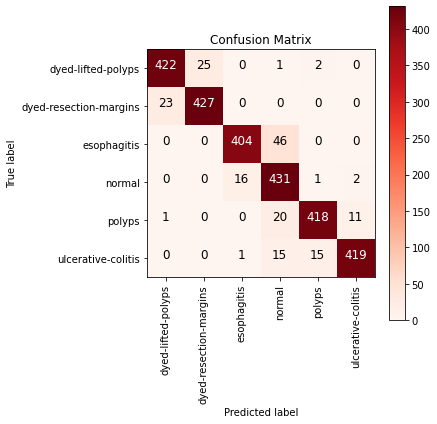

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

[[422  25   0   1   2   0]
 [ 23 427   0   0   0   0]
 [  0   0 404  46   0   0]
 [  0   0  16 431   1   2]
 [  1   0   0  20 418  11]
 [  0   0   1  15  15 419]]


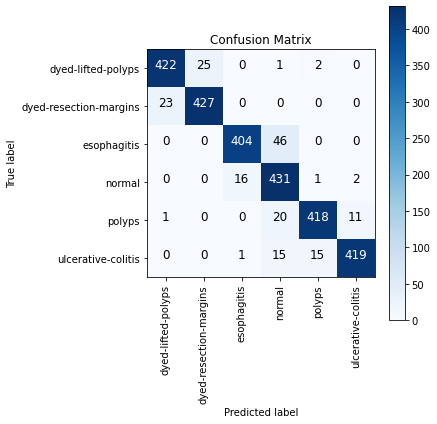

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

[[422  25   0   1   2   0]
 [ 23 427   0   0   0   0]
 [  0   0 404  46   0   0]
 [  0   0  16 431   1   2]
 [  1   0   0  20 418  11]
 [  0   0   1  15  15 419]]


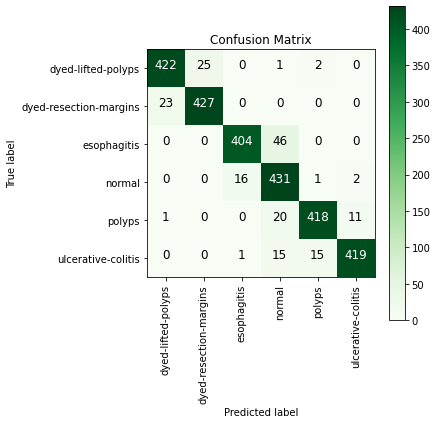

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Greens):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

IndexError: ignored

In [ ]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

6 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c7cadc0>
13 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c370730>
20 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c372310>
27 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c6d1610>
34 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c4cbaf0>
41 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c74fa90>
48 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c4d90a0>
55 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f8c5c6b7100>


AxisError: ignored

In [27]:
!mkdir checkpoints
!cp checkpoint ./checkpoints
!cp checkpoint.data-00000-of-00001 ./checkpoints
!cp checkpoint.index ./checkpoints

In [28]:
!zip -r spatialconvmixer_chck.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/checkpoint (deflated 48%)
  adding: checkpoints/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/checkpoint.index (deflated 80%)
